# Data Collection

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json

## A Simple Scraper for Zhihu

In [2]:
def get_page(url):

    headers = {
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
    }

    try:
        r = requests.get(url, headers=headers)
        page = r.content
        return page

    except requests.HTTPError as e:
        print(e)
        print("HTTPError")

    except requests.RequestException as e:
        print(e)

    except:
        print("Unknown Error!")


def zhihu_scraper(id=None, total=1000):

    file = pd.DataFrame()

    page_number = 0

    base = 'https://www.zhihu.com/api/v4/questions/' + str(id) + '/answers?'
    include = 'data%5B%2A%5D.is_normal%2Cadmin_closed_comment%2Creward_info%2Cis_collapsed%2Cannotation_action%2Cannotation_detail%2Ccollapse_reason%2Cis_sticky%2Ccollapsed_by%2Csuggest_edit%2Ccomment_count%2Ccan_comment%2Ccontent%2Ceditable_content%2Cattachment%2Cvoteup_count%2Creshipment_settings%2Ccomment_permission%2Ccreated_time%2Cupdated_time%2Creview_info%2Crelevant_info%2Cquestion%2Cexcerpt%2Cis_labeled%2Cpaid_info%2Cpaid_info_content%2Crelationship.is_authorized%2Cis_author%2Cvoting%2Cis_thanked%2Cis_nothelp%2Cis_recognized%3Bdata%5B%2A%5D.mark_infos%5B%2A%5D.url%3Bdata%5B%2A%5D.author.follower_count%2Cbadge%5B%2A%5D.topics%3Bdata%5B%2A%5D.settings.table_of_content.enabled'

    while (page_number < total):

        question_url = base + 'include=' + include + '&limit=5&' + \
            'offset=' + str(page_number) + '&platform=desktop&sort_by=default'

        page = get_page(question_url)
        entries = json.loads(page)['data']

        if len(entries) != 0:

            answers = list()

            for i in entries:
                answer = list()

                answer.append(i['author']['name'])
                answer.append(i['author']['gender'])
                answer.append(i['author']['follower_count'])

                answer.append(i['voteup_count'])
                answer.append(i['comment_count'])
                answer.append(i["url"])
                answer.append(i['content'])  # Get the answer content

                answers.append(answer)

            file = file.append(pd.DataFrame(answers), ignore_index=True)

        else:
            pass

        page_number += 5

    file.columns = ["name", "gender", "follower_count",
                    "voteup_count", "comment_count", "url", "content"]

    return file

In [3]:
if __name__ == '__main__':
    nationalism = zhihu_scraper(id=24449468)
    nationalism.to_csv("nationalism.csv", encoding="utf-8-sig")

# Text Analysis
## Preprocessing

In [4]:
import jieba
import re
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import corpora, models, similarities

# Plotting tools
import pyLDAvis
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
def remove_chars(sentence):

    eng = '[a-zA-Z0-9]'
    url = r'[a-z]*[:.]+\s+'
    emoji = re.compile(u'[^\s1234567890:：' + '\u4e00-\u9fa5]+')
    mark = '[’!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+'
    result = re.sub(eng, '', str(sentence))
    result = re.sub(url, '', result)
    result = re.sub(emoji, '', result)
    result = re.sub(mark, '', result)
    sent= "".join(result)

    return sent

def seg_depart(sentence):
    sentence_depart = jieba.cut(sentence)
    stopwords = [line.strip() for line in open('cn_stopwords.txt', encoding='UTF-8').readlines()]
    outstr = ''
    for word in sentence_depart:
        if word not in stopwords:
            outstr += word
            outstr += " "
    return outstr

In [6]:
nationalism = pd.read_csv("nationalism.csv", encoding="utf-8-sig")

In [7]:
texts = []
for text in nationalism.content:
    text = remove_chars(text)
    if len(seg_depart(text)) != 0:
        texts.append(seg_depart(text))

Building prefix dict from the default dictionary ...
2021-12-16 23:54:49,674 : DEBUG : Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/d2/vsfry6xx26x19vd8b7c7qjlc0000gn/T/jieba.cache
2021-12-16 23:54:49,676 : DEBUG : Loading model from cache /var/folders/d2/vsfry6xx26x19vd8b7c7qjlc0000gn/T/jieba.cache
Loading model cost 0.618 seconds.
2021-12-16 23:54:50,295 : DEBUG : Loading model cost 0.618 seconds.
Prefix dict has been built successfully.
2021-12-16 23:54:50,296 : DEBUG : Prefix dict has been built successfully.


In [8]:
## Remove new line tag
words = []
for i in texts:
    word = []
    for j in i.split(" ")[:-1]:
        if len(j) != 0 and j != "\n" and j != "\u3000":
            word.append(j)
    words.append(word)

## LDA

In [9]:
id2word = corpora.Dictionary(words)
corpus = [id2word.doc2bow(sentence) for sentence in words]

In [10]:
## Search the best perplexity and coherence scores
perplexity_scores = []
coherence_scores = []
model_list = []
for num_topics in range(2, 31, 1):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
    
    model_list.append(lda_model)
    perplexity_scores.append(round(lda_model.log_perplexity(corpus), 3))
    coherencemodel = CoherenceModel(
        model=lda_model, texts=words, dictionary=id2word, coherence='c_v')
    coherence_scores.append(round(coherencemodel.get_coherence(), 3))

In [11]:
lda_stats = pd.DataFrame({
    "Number": range(2, 31, 1),
    "Coherence": coherence_scores,
    "Perplexity": perplexity_scores
})

In [12]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import LinearAxis, Range1d, ColumnDataSource
from bokeh.palettes import Colorblind

colors = Colorblind[3]

output_file("ldastats.html")
source = ColumnDataSource(lda_stats)

# Scree plot
pl = figure(width=808, height=438, title="Perplexity and Coherence Scores over Number of Topics",
            toolbar_location=None, tools="hover",
            tooltips=[("# of Topics", "@Number"), ("Perplexity Score", "@Perplexity"), ("Coherence Score", "@Coherence")])

pl.line(x="Number", y="Coherence", source=source,
        width=2, color=colors[1])
pl.y_range = Range1d(0, 1)


# Line plot for another y axis
pl.extra_y_ranges['Perplexity Scores'] = Range1d(start=-20, end=0)
pl.add_layout(LinearAxis(y_range_name='Perplexity Scores',
              axis_label='Perplexity Scores'), 'right')
pl.line(x="Number", y="Perplexity", source=source,
        width=2, y_range_name="Perplexity Scores", color=colors[0])


show(pl)

In [13]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=13,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [14]:
pprint(lda_model.show_topics(num_topics=13, formatted=True))

[(0,
  '0.002*"现代人" + 0.002*"法宝" + 0.002*"自杀" + 0.001*"词是" + 0.001*"提炼" + '
  '0.001*"肢解" + 0.000*"救心丸" + 0.000*"上头" + 0.000*"生殖隔离" + 0.000*"时服"'),
 (1,
  '0.017*"利维坦" + 0.016*"宣扬" + 0.010*"掩盖" + 0.009*"特权" + 0.009*"民权" + '
  '0.007*"广东" + 0.006*"民生" + 0.006*"出口" + 0.006*"帽子" + 0.006*"殖民主义"'),
 (2,
  '0.019*"狗" + 0.018*"立场" + 0.013*"国家主义" + 0.010*"普世" + 0.009*"翻译" + '
  '0.009*"爆发" + 0.006*"占有" + 0.006*"开除" + 0.006*"美利坚" + 0.005*"伤害"'),
 (3,
  '0.021*"资产阶级" + 0.020*"美国" + 0.020*"无产阶级" + 0.012*"利益" + 0.010*"发展" + '
  '0.010*"资本" + 0.010*"帝国主义" + 0.010*"国际主义" + 0.009*"共同体" + 0.007*"革命"'),
 (4,
  '0.005*"更进一步" + 0.004*"整天" + 0.004*"笑" + 0.003*"刚" + 0.003*"可取" + 0.002*"燃烧" '
  '+ 0.002*"拉拢" + 0.002*"本族" + 0.002*"舔" + 0.002*"砸"'),
 (5,
  '0.011*"盎格鲁" + 0.010*"双刃剑" + 0.008*"打仗" + 0.007*"撒克逊人" + 0.005*"改善" + '
  '0.005*"即将" + 0.005*"对错" + 0.003*"大同" + 0.003*"便利" + 0.002*"欺压"'),
 (6,
  '0.018*"欺负" + 0.002*"稳固" + 0.002*"结实" + 0.001*"自然科学" + 0.001*"身后" + '
  '0.001*"社会科学" + 0.001*"外地人" + 0.001*"

### Chinese WordCloud

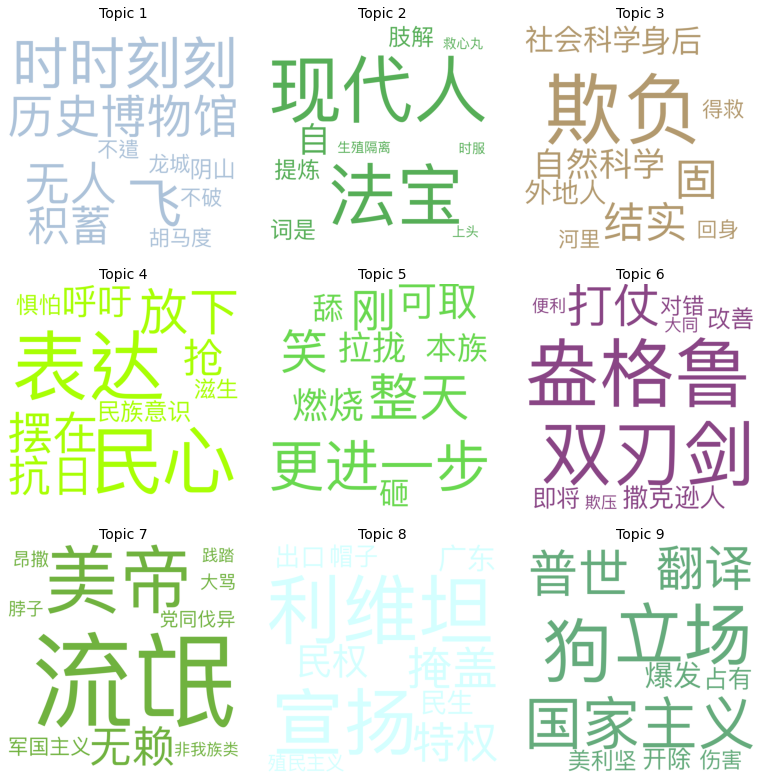

In [15]:
# more colors: 'mcolors.XKCD_COLORS'
cols = [color for name, color in mcolors.XKCD_COLORS.items()] 
my_stopwords = [line.strip() for line in open(
        'cn_stopwords.txt', encoding='UTF-8').readlines()]


cloud = WordCloud(stopwords=my_stopwords,
                  font_path="/System/Library/fonts/PingFang.ttc",
                  background_color='white',
                  width=750,
                  height=750,
                  max_words=30,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)


fig, axes = plt.subplots(3, 3, figsize=(11,11), sharex=False, sharey=True)

topics= lda_model.show_topics(num_topics=12, formatted=False)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=14))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig("wordcloud.png", dpi=400)

## `textrank4zh`

In [16]:
from __future__ import print_function
import sys
try:
    reload(sys)
    sys.setdefaultencoding('utf-8')
except:
    pass
import codecs
from textrank4zh import TextRank4Keyword, TextRank4Sentence

In [18]:
text = remove_chars(nationalism.content[2])
tr4w = TextRank4Keyword()

tr4w.analyze(text=text, lower=True, window=2) 

print( '关键词：' )
for item in tr4w.get_keywords(20, word_min_len=1):
    print(item.word, item.weight)

print()
print( '关键短语：' )
for phrase in tr4w.get_keyphrases(keywords_num=20, min_occur_num= 2):
    print(phrase)

tr4s = TextRank4Sentence()
tr4s.analyze(text=text, lower=True, source = 'all_filters')

print()
print( '摘要：' )
for item in tr4s.get_key_sentences(num=3):
    print(item.index, item.weight, item.sentence)

关键词：
恐怖分子 0.014810179728208514
以色列 0.01444787150231469
拉宾 0.01217250629627569
飞机 0.01075375780978276
行动 0.010452302891981832
人 0.00942089384205837
人质 0.008982491157889433
上 0.007469985381924212
计划 0.007078490043175396
佩雷斯 0.006776054803807009
阿明 0.006388772927335733
机场 0.005412268503711061
乌干达 0.005252283255762433
时 0.005228657595120965
恩德培 0.005133805726358206
没有 0.004590579214317485
乘客 0.00454405449231926
法国 0.0044017383825072955
军事行动 0.004326099607147035
犹太人 0.00429881702349456

关键短语：
恩德培机场
以色列人
飞机上

摘要：
65 0.014883414511197344 月  日上午  时  分拉宾收到一封由阿明转达的情报看完后他不由得倒吸一口凉气现在靴子落地了以色列面临的境遇一清二楚恐怖分子提出的是
66 0.014213450219814844 释放人质的条件是在  小时内释放分别关押在  个国家的恐怖分子包括以色列的  人西德的  人肯尼亚  人瑞士  人法国  人
75 0.013920175380719293 他慷慨激昂地说：如果我们屈服于恐怖分子的要求释放这里的恐怖分子那么所有人都会理解我们但没有人会尊敬我们然而如果我们采取军事行动解救人质那么有可能没人理解我们但大家都会尊敬我们
